In [1]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import missingno as msno

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# 1. Create transformer

> 트랜스포머 기반 챗봇 구현을 위해 트랜스포머 모델을 기반으로 하는 인코더-디코더를 구성하는 작업을 진행한다.

## 1.1 positional Encoding

> 자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 진행한다.<br>
> 트랜스포머도 위와같은 과정을 진행하지만, 임베딩 벡터에 포지셔널 인코딩의 결과 값을 더해준 뒤에 입력으로 사용한다는 점이 다르다.<br>
> 이에, 트랜스포머에 사용할 포지셔널 인코딩을 구현한다.

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    def positional_encoding(self, position, d_model):

        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

> 문장 최대 길이가 50이고, 워드 임베딩 차원이 512인 모델의 입력 벡터 조건을 가설로 하였을때, 입력 벡터 모양은 아래 그림과 같다.

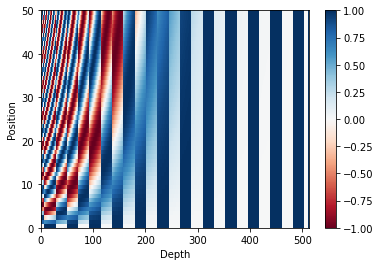

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 1.2 Scaled Dot Product Attention

> 트랜스포머에는 어텐션 함수가 사용되며, 입력 문장 내의 단어들끼리 유사도를 계산하여 연관되었을 확률이 높은 단어를 찾는다.<br>
> 단어 간 유사도를 구하기 위해선, 어텐션 함수의 쿼리(Query), 키(Key), 밸류(Value)을 활용하여 어텐션 값을 구해야한다.<br>
> 이에, 어텐션 값을 구하기 위한 스케일드 닷 프로덕트 어텐션 함수를 구현한다.

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
    # step1. 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # step2. 가중치 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # step3. 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # step4. softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # step5. 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    
    return output

## 1.3 Multi Head Attention

> 단일 어텐션으로는 놓칠 수 있는 단어 유사도 정보를 식별하기 위해 어텐션을 병렬로 수행하는 멀티 헤드 어텐션을 구현한다.<br>
> 내부적으로는 Scaled Dot Product Attention를 사용한다.

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # step1. Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # step2. 병렬 연산 구현
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # #step3. Scaled Dot Product Attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # step4. 어텐션 연산 후, 각 결과를 다시 연결(concatenate)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

        # step5. 최종 결과에 Dense를 한 번 더 적용
        outputs = self.dense(concat_attention)

        return outputs

## 1.4 Masking

> 마스크는 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법이다.<br>
> 트랜스포머의 어텐션 함수에는 패딩 마스킹(Padding Masking)과 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)를 사용한다.<br>
> 이에, 패딩 마스킹(Padding Masking)과 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)을 구현하는 과정을 진행한다.<br>

## 1.4.1 Padding Masking

> 패딩은 hyper parameter로 설정한 문장 최대 길이보다 짧은 문장의 경우에 숫자 0을 채워서 모든 문장의 길이를 동일하게 해주는 방법이다.<br>
> 패딩으로 가공한 숫자 데이터 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있다.<br>
> 이에, 숫자 0인 위치를 체크하는 패딩 마스킹을 구현한다. 

In [6]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


> 숫자 0인 index 위치를 잘 찾는 모습을 확인 할 수 있다.

## 1.4.2 Look-ahead masking

> 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있다.<br>
> 즉, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다.<br>
> 그러나, 훈련 모델의 목표는 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것이다.<br>
> 위 문제를 해결하기 위해, 현 위치를 기준으로 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 함수를 구현한다.

In [8]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    
    return tf.maximum(look_ahead_mask, padding_mask)

In [9]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


> 이터레이터 index 위치를 기준으로 다음 단어가 1로 잘 가려져 있음을 확인할 수 있다.<br>
> 숫자가 0이 포함된 데이터를 Look-ahead masking했을때의 결과도 확인한다.

In [10]:
print(create_look_ahead_mask(tf.constant([[0, 5, 0, 4, 8]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 1. 0. 1.]
   [1. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


> 숫자 0은 의미가 없는 정보이므로 이터레이터 index 위치와 상관없이 1로 정보를 가리는 모습을 확인할 수 있다.

## 1.5 Make Encoder layer for transfomer

> 트랜스포머의 인코더는 셀프 어텐션과 피드 포워드 신경망 2개의 서브 layer를 병합하여 1개의 인코더로 구성된다.<br>
> 트랜스포머의 인코더의 구성 기능 중 하나인 셀프 어텐션은 이전 1.3에서 구현한 멀티 헤드 어텐션을 병렬로 구성한 형태이다.<br>
> 위 구성을 바탕으로 트랜스포머의 인코더의 메인층을 설계하는 함수를 구현한다.

In [11]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # step1. Use padding mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # step2. first sub layer: Multi Head Attention (Self attention)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs, 'key': inputs, 'value': inputs, 'mask': padding_mask})

    # step3. Use dropout and layer normalization in attention result -> 모델 훈련 용이성 증가
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # step4. second sub layer : two completely connected layers
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # step5. Use dropout과 layer normalization  in two completely connected layers  -> 모델 훈련 용이성 증가
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

> 위에서 구현한 인코더의 메인층을 임베딩 층과 포지셔널 인코딩을 연경한다.<br>
> 이는 본인이 원하는 만큼 인코더를 메인층을 쌓을 수 있도록 구성함으로써 트랜스포머의 인코더를 완성한다.<br>
> 'num_layers' hyper parameter로 인코더 메인층을 쌓는 횟수를 지정하여 트랜스포머 인코더를 구성한다.

In [12]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # step1. Use padding mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # step2. Embedding layer
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # step3. Positional Encoding
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # step4. num_layers만큼 인코더 메인층 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads,
                                dropout=dropout,name="encoder_layer_{}".format(i),)([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 1.6 Make Decoder layer for transfomer

> 트랜스포머의 디코더는 '셀프 어텐션'과 '인코더-디코더 어텐션', '피드 포워드 신경망', 총 3개의 서브 layer를 병합하여 1개의 디코더로 구성된다.
> 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있다.<br>
> 위 특징을 활용하여 디코더는 인코더가 입력받은 문장 정보를 출력한 값을 입력값으로 전달받을 수 있다.<br>
> 위 구성을 바탕으로 트랜스포머의 디코더의 메인층을 설계하는 함수를 구현한다.<br>

In [13]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # step1. first sub layer: Multi Head Attention (Self attention)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, 'mask': look_ahead_mask})

    # step2. Use dropout and layer normalization in attention result -> 모델 훈련 용이성 증가
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # step3. second sub layer : Maks Multi Head Attention (Encoder-Decoder Attention)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, 'mask': padding_mask})

    # step4. Use dropout과 layer normalization in Maks Multi Head Attention result  -> 모델 훈련 용이성 증가
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # step5. Third sub layer : two completely connected layers
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # step6. Use dropout과 layer normalization  in two completely connected layers  -> 모델 훈련 용이성 증가
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

> 위에서 구현한 디코더의 메인층을 임베딩 층과 포지셔널 인코딩을 연경한다.<br>
> 이는 본인이 원하는 만큼 디코더를 메인층을 쌓을 수 있도록 구성함으로써 트랜스포머의 디코더를 완성한다.<br>
> 'num_layers' hyper parameter로 디코더 메인층을 쌓는 횟수를 지정하여 트랜스포머 디코더를 구성한다.

In [14]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')                                   
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # step1. Embedding layer
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # step2. Positional Encoding
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # step3. Use dropout
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout,name='decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

# 2. Korean data load

> 이별과 관련된 주제로 개설된 '사랑보다 아름다운 실연' Daum카페로부터 이별 관련 한국어 데이터 11,876개을 활용한다.<br>
> 한국어 데이터를 메모리에 할당 후 데이터를 확인하는 작업을 진행한다. 

In [15]:
os.getenv('HOME')

'/aiffel'

In [16]:
korean_data = pd.read_csv(os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv')
korean_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [17]:
print(len(korean_data))

11823


> 불러온 데이터를 확인한 결과 아래와 같은 정보를 획득했다.<br>
> 1. Q(질문) - 다음 카페 질문 게시글 제목 데이터이다.<br>
> 2. A(답변) - 게시글의 답변 데이터이다.<br>
> 3. Label - 어떤 의미가 담긴 정보인지 불명.<br>

> 데이터의 총 개수는 11,823개이다.

# 3. Data processing

> 모델 구성을 위해 데이터를 목적에 맞게 가공할 수 있도록, 데이터의 형태를 분석하는 과정을 진행한다.

## 3.1 Check missing values

> 불러온 데이터에 결측치가 있는지 확인하는 작업을 수행한다.

<AxesSubplot:>

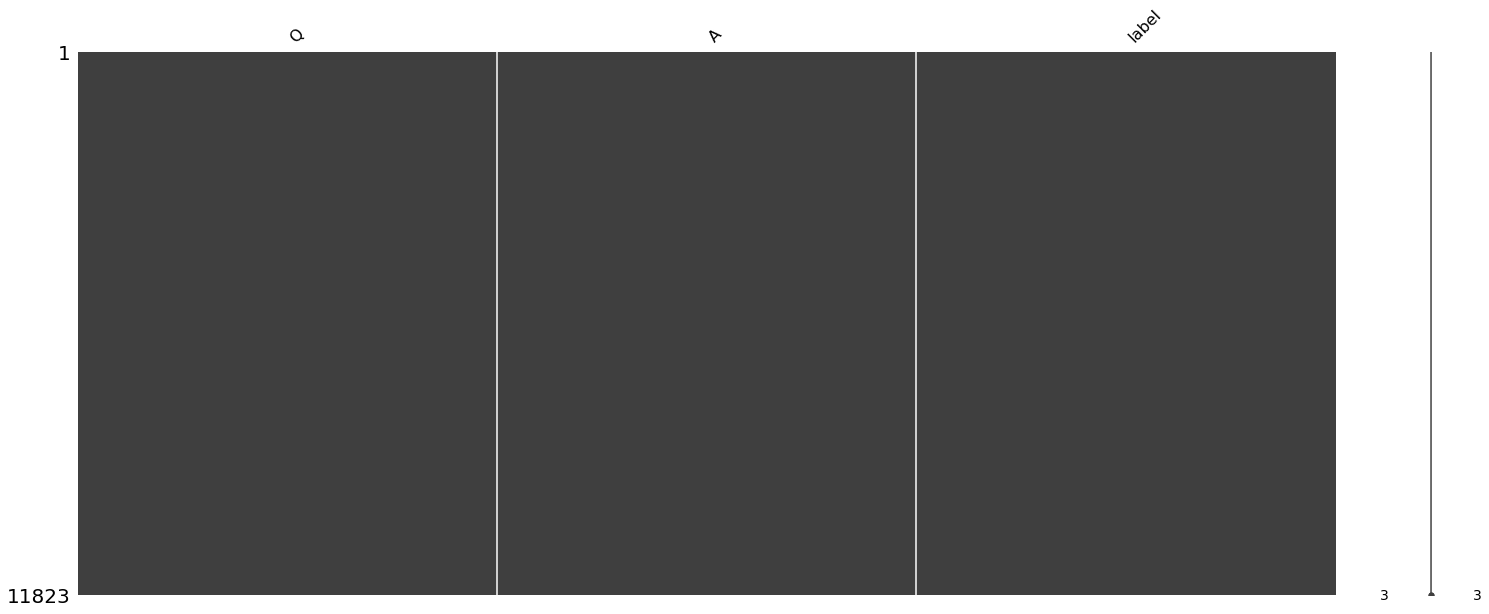

In [18]:
msno.matrix(korean_data)

<AxesSubplot:>

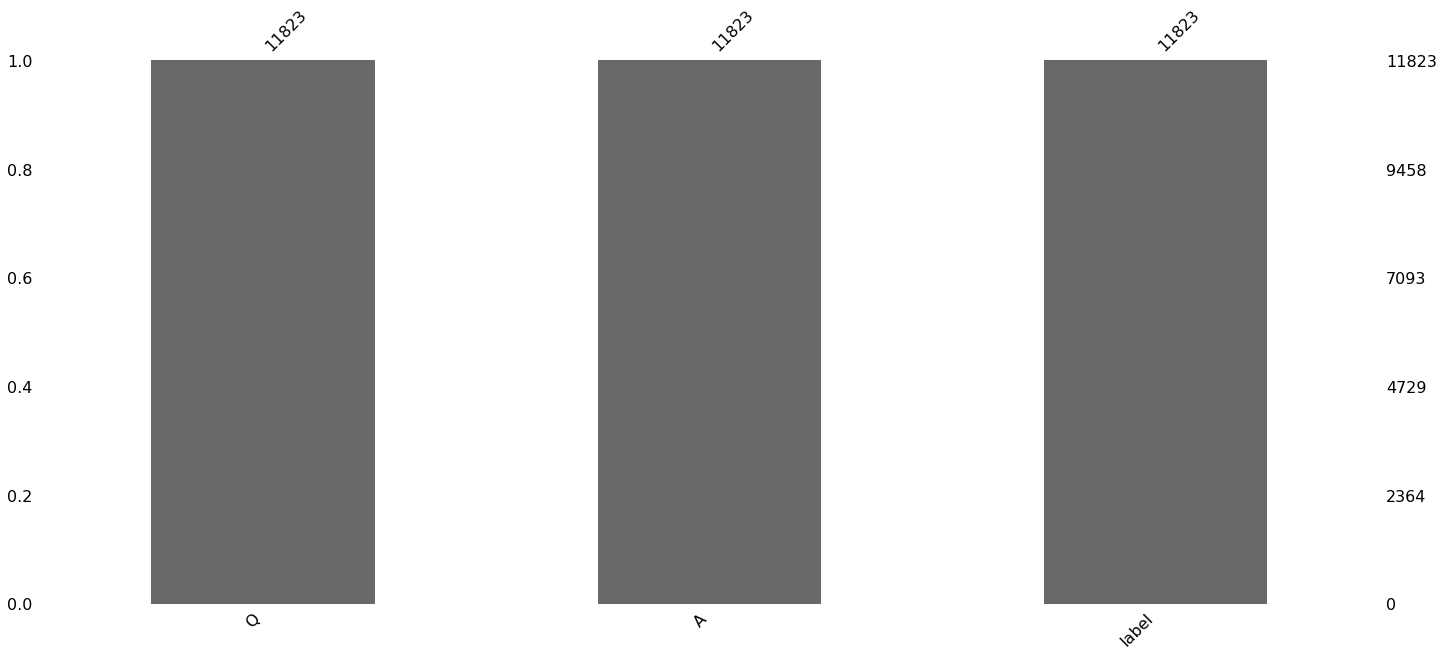

In [19]:
msno.bar(korean_data)

> 한국어 데이터를 시각적, 수치적 분석을 진행한 결과 결측치가 확인되지 않았다.

## 3.2 sentence data preprocessing

> 특정 조건 단어 이외의 특수문자, 공백 등을 모두 제거하는 전처리 함수를 구현한다. 이는 필터의 역할을 수행한다.

In [20]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)  
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣1-9a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

> 한국어 데이터의 질문 데이터와 답변 데이터를 모델 학습에 적합한 형태로 정규화하는 공정을 진행한다.

In [21]:
question = list(map(preprocess_sentence, korean_data['Q']))
answer = list(map(preprocess_sentence, korean_data['A']))

> 질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야하므로 샘플 개수를 확인한다.

In [22]:
print('question 샘플 수 :', len(question))
print('answer 샘플 수 :', len(answer))

question 샘플 수 : 11823
answer 샘플 수 : 11823


> 질문과 답변이 병렬적으로 저장 및 전처리가 올바르게 진행되었는지 확인한다.

In [23]:
print('전처리 후의 17번째 질문 : {}'.format(question[16]))
print('전처리 후의 17번째 답변: {}'.format(answer[16]))

전처리 후의 17번째 질문 : 가상화폐 쫄딱 망함
전처리 후의 17번째 답변: 어서 잊고 새출발 하세요 .


> 답변자가 현자다. 코인에 자질 없는것 같으면 손 떼는게 답이다.<br>
> 이별 관련 카페 기반 데이터에 알맞게, 코인과 이별하는 주제로 질문과 답변이 병렬적으로 저장이 잘 되었음을 확인할 수 있다.<br>
> 또한 답변에서 .(온점)이 공백으로 잘 전처리 되었음을 확인할 수 있다.

## 3.3 Make vocabulary

> 전처리된 데이터를 활용하여 토크나이저 기법으로 단어장을 생성한다.

In [24]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(question + answer, target_vocab_size=2**11)

In [25]:
tokenizer.vocab_size

2046

> Q(question) + A(answer)를 병합한 한국어 데이터를 토크나이저한 결과 2046 크기의 단어장이 생성되었다.

> 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'을 임의로 단어장에 정수 데이터로 추가한다.

In [26]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

> '시작 토큰'과 '종료 토큰, 두 개의 토큰을 추가해 주었기 때문에 단어장의 크기를 임의로 +2 증가시킨다.

In [27]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

2048


> 시작 토큰과 종료 토큰에 부여된 정수를 확인하는 작업을 진행한다.

In [28]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [2046]
END_TOKEN의 번호 : [2047]


## 3.4 Encoding and padding each word with a unique integer

> tokenizer.encode()을 활용하여 각 단어를 정수로 변환하고, tokenizer.decode()으로 정수 시퀀스를 단어 시퀀스로 변환하는 작업을 진행한다.<br>
> 문장의 최대 길이는 40으로 제한다.

In [29]:
MAX_LENGTH = 40

In [30]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    # step1. 정수 인코딩 과정에 시작 토큰과 종료 토큰 추가
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # step2. 최대 길이 40 이하인 데이터만, 데이터세트 구성
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 문장의 최대 길이 40으로 데이터세트 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [31]:
question, answer = tokenize_and_filter(question, answer)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: ',len(question))
print('필터링 후의 답변 샘플 개수: ',len(answer))

단어장의 크기 : 2048
필터링 후의 질문 샘플 개수:  11822
필터링 후의 답변 샘플 개수:  11822


> question, answer의 각 문장과 각 단어를 고유한 정수로 인코딩 및 패딩한 결과, 기존 11823개중 11822개의 데이터가 기준에 부합했다.

## 3.5 Use Teacher Forcing

> 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는  tf.data.Dataset API을 활용하여 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 진행한다.<br>
> 위 과정을 위해 디코더의 입력과 실제값(레이블)을 정의해주는 교사 강요(Teacher Forcing)라는 언어 모델의 훈련 기법을 활용하여 트랜스포머 디코더에 사용한다.

> batch_size는 64로 설정하여 1 epoch 시 약 184회 데이터를 훈련할 수 있도록 구성한다.<br>
> 입력할 데이터 개수가 11822이므로 BUFFER_SIZE를 20,000으로 충분히 설정한다.

In [33]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': question,
        'dec_inputs': answer[:, :-1]
    },
    {
        'outputs': answer[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 4. Model design and train

> 위 과정으로 얻은 인코더 층과 디코더 층을 활용하여 트랜스포머를 정의한다.

In [34]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)

    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout,)(inputs=[inputs, enc_padding_mask])
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 4.1 Create model

> 모델 하이퍼 파라미터를 설정하고 트랜스포머 모델을 생성한다.

In [42]:
tf.keras.backend.clear_session()

# Hyper parameter
NUM_LAYERS = 8 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

In [43]:
model = transformer(vocab_size=VOCAB_SIZE, num_layers=NUM_LAYERS, units=UNITS, d_model=D_MODEL, num_heads=NUM_HEADS, dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13672448    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 4.2 Loss function

> 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용하는 손실함수를 구현한다.

In [44]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

## 4.3 Custom learning rate scheduling

> 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)을 활용하여 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하도록 구성한다.

In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

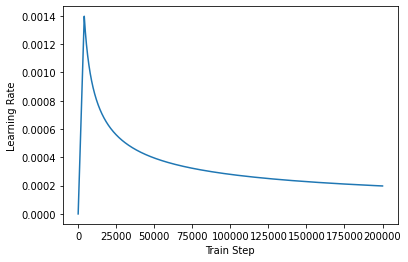

In [46]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

> 위에서 정의한 커스텀 학습률 스케줄링 계획을 시각화한 결과, 학습 초기에는 학습율이 높았으나, 이후로는 감소하는 모습을 확인 할 수 있다.

## 4.4 Compile model

In [47]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## 4.5 Train model

In [48]:
EPOCHS = 40
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
185/185 [==============================] - 133s 557ms/step - loss: 1.6510 - accuracy: 0.0169
Epoch 2/40
185/185 [==============================] - 103s 557ms/step - loss: 1.3549 - accuracy: 0.0472
Epoch 3/40
185/185 [==============================] - 103s 557ms/step - loss: 1.2507 - accuracy: 0.0547
Epoch 4/40
185/185 [==============================] - 103s 558ms/step - loss: 1.2100 - accuracy: 0.0568
Epoch 5/40
185/185 [==============================] - 103s 557ms/step - loss: 1.1927 - accuracy: 0.0573
Epoch 6/40
185/185 [==============================] - 103s 558ms/step - loss: 1.1332 - accuracy: 0.0585
Epoch 7/40
185/185 [==============================] - 103s 557ms/step - loss: 1.0715 - accuracy: 0.0617
Epoch 8/40
185/185 [==============================] - 103s 558ms/step - loss: 1.0189 - accuracy: 0.0637
Epoch 9/40
185/185 [==============================] - 103s 557ms/step - loss: 0.9860 - accuracy: 0.0674
Epoch 10/40
185/185 [==============================] - 104s 562m

# 5. Predict chatbot


> 위에서 훈련한 모델을 활용하여 유저가 질문한 문장에 대해 예측하고 답변하는 챗봇을 구현한다.<br>
> 챗봇이 질문에 대한 문장을 생성하는 과정은 아래와 같다.
<br><br>
> 1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.<br>
> 2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.<br>
> 3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.<br>
> 4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.<br>
> 5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.<br>
> 6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.<br><br>

>위의 과정을 진행하는 decoder_inference() 함수를 구현한다.

In [49]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

> 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 구현한다

In [50]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

# 6. Test chatbot

> 훈련된 모델의 성능을 테스트하여 성능을 평가하는 과정을 진행한다.<br>
> 모델의 훈련 데이터는 이별과 관련된 데이터였으므로, 질문도 이별을 주제로 진행하고자 한다.

In [52]:
sentence_generation('남친과 헤어졌어')

입력 : 남친과 헤어졌어
출력 : 많이 답답할거라 생각해요 .


'많이 답답할거라 생각해요 .'

> 남친과 헤어졌다는 질문자의 심정을 헤아리며 공감하는 모습을 보여주고 있다.<br>
> 훈련 모델은 챗봇이므로, 위 문장과 이어서 대화하듯이 질문을 진행한다.

In [56]:
sentence_generation('그는 나쁜 사람이였어')

입력 : 그는 나쁜 사람이였어
출력 : 미련이 남았을지도 몰라요 .


'미련이 남았을지도 몰라요 .'

> 어줍짢은 위로 대신, 당사자의 현 심정을 파악하고, 과거에 엮이지 말고 나아가도록 유도하는 모습을 보여주고 있다.<br>
> 이번에는 이성이 아닌 동성과의 이별에 대한 질문을 실험을 진행한다.

In [67]:
sentence_generation('어제 친구와 헤어졌어요')

입력 : 어제 친구와 헤어졌어요
출력 : 또 다른 시작을 뜻하기도 해요 .


'또 다른 시작을 뜻하기도 해요 .'

> 지나간 인연에 얽매이지 말고 새로운 인연을 만나라고 위로해주는 모습이다.<br>
> 이별과 관련된 주제에는 수준급의 답변을 하는 모습을 보여준다.<br>
> 이에, 이별과 관련없는 주제로 질문했을때 챗봇의 답변을 확인하는 실험을 진행한다.

In [68]:
sentence_generation('저녁에 치킨 ㄱ?')

입력 : 저녁에 치킨 ㄱ?
출력 : 같이 가요 .


'같이 가요 .'

> 챗봇도 치킨은 못참는것 같다. 질문자의 의도를 잘 파악하고 같이 가자는 인싸의 기질도 보여주고 있다.

In [75]:
sentence_generation('시험 끝났다')

입력 : 시험 끝났다
출력 : 좋은 결과 있을 거예요 !


'좋은 결과 있을 거예요 !'

> 시험을 본 질문자에게 좋은 덕담을 건네는 모습을 보여준다.

In [79]:
sentence_generation('할게 너무 많아')

입력 : 할게 너무 많아
출력 : 건강에 유의하세요 .


'건강에 유의하세요 .'

> 워커 홀릭으로 일하다가 건강을 놓치지 말라는 조언을 해주는 모습이다.

# 후기

> 위 챗봇의 테스트 결과는 잘 나왔지만, 처음에 만든 챗봇 모델은 질문에 대해 동문서답을 하는 경우가 대부분이였습니다.<br>
> 그래서 모델의 하이퍼 파라미터를 다시 재조정하며 여러번 튜닝하는 작업을 거치며 만든 결과, 위와같이 질문의 의도에 맞는 올바른 답을 하는 챗봇을 만들 수 있었습니다.<br>
> 기존 인코더와 디코더의 층 개수를 2에서 8로 4배 증가하고, 인코더와 디코더 내부의 입, 출력의 고정 차원을 256에서 512로 2배 증가시켜 모델을 훈련 했을때, 학습 정확도는 기존 모델보다 낮았지만, 실제 질문 예측 성능에서는 가장 좋은 결과를 보여주었습니다.<br>
> 그럼에도, 기존 훈련 데이터의 양이 1만여개밖에 되지 않아, 답변의 다양성은 한정되어있는 모습을 보여주었습니다.<br>
> 향후, 학습 데이터 량을 늘려서 모델을 재 훈련한다면 지금보다 더 융통성있고 재치있는 챗봇이 만들어질것이라 생각합니다.<br>